<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/2019_tf/autoencoders_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

<img src='https://djcordhose.github.io/ai/img/autoencoder_schema.jpg'>

https://blog.keras.io/building-autoencoders-in-keras.html

### More great experiments by Sean Pedersen (@seanpedersen96)

https://colab.research.google.com/drive/1f73wONMp8U2LvAmN0MNGyflqGFog0g2S

In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.12.0


In [2]:
from tensorflow.keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


## Dense Autoencoder

In [0]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Flatten, GlobalAveragePooling1D, Dense, LSTM, GRU, SimpleRNN, Bidirectional, Embedding
from tensorflow.keras.models import Sequential, Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(units=encoding_dim, activation='relu', name="encoder")(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(units=784, activation='sigmoid', name="decoder")(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(inputs=input_img, outputs=decoded)

# loss on pixel level
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [4]:
BATCH_SIZE = 256

# We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

%time history = autoencoder.fit(x_train, x_train, epochs=60, batch_size=BATCH_SIZE, shuffle=True, validation_data=(x_test, x_test), verbose=0)

CPU times: user 1min 26s, sys: 11.9 s, total: 1min 37s
Wall time: 1min 12s


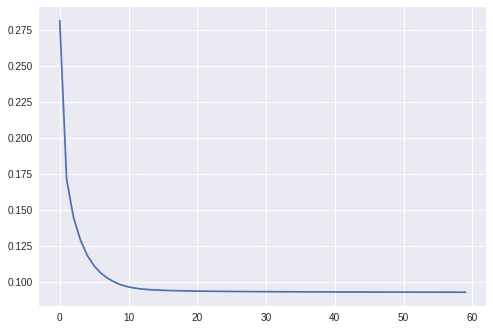

In [5]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])

In [6]:
autoencoder.evaluate(x_train, x_train, batch_size=BATCH_SIZE)

60000/60000 [==============================] - 1s 10us/step


0.09248494243621826

In [0]:
# this model maps an input to its encoded representation
encoder = Model(inputs=input_img, outputs=encoded)

In [0]:
latent_representation = encoder.predict(x_test)

In [9]:
# compressed version of the image
len(latent_representation[0])

32

In [0]:
# let's see if we can reproduce it
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.get_layer("decoder")
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [0]:
# reproduce using decoder
decoded_imgs = decoder.predict(latent_representation)

In [12]:
len(decoded_imgs[0])

784

In [0]:
def plot(original, decoded, n=10):
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # display original
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(original[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(decoded[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

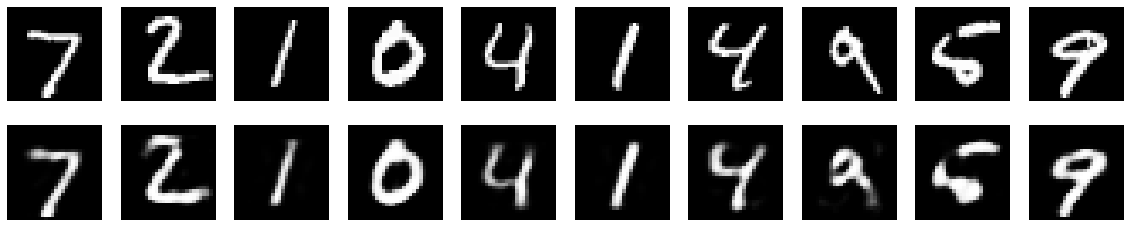

In [14]:
plot(x_test, decoded_imgs)

## Convolutional AE

In [0]:
from tensorflow.keras.layers import Input, Flatten, GlobalAveragePooling1D, Dense, Conv2D, MaxPooling2D, UpSampling2D

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='decoder')(x)

# this model maps an input to its reconstruction
autoencoder = Model(inputs=input_img, outputs=decoded)

# loss on pixel level
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [16]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

BATCH_SIZE = 128
%time history = autoencoder.fit(x_train, x_train, epochs=60, batch_size=BATCH_SIZE, shuffle=True, validation_data=(x_test, x_test), verbose=0)

Using TensorFlow backend.


CPU times: user 5min 11s, sys: 1min 3s, total: 6min 15s
Wall time: 5min 12s


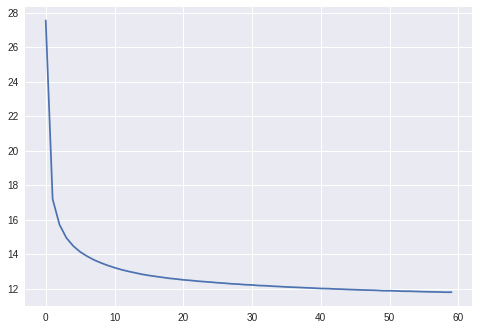

In [17]:
plt.plot(history.history['loss'])

In [18]:
autoencoder.evaluate(x_train, x_train, batch_size=BATCH_SIZE)

60000/60000 [==============================] - 2s 27us/step


11.787032884216309

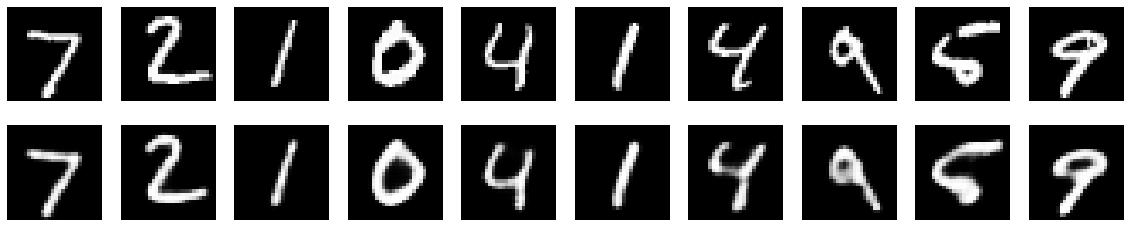

In [19]:
decoded_imgs = autoencoder.predict(x_test)
plot(x_test, decoded_imgs)